## 1. Make cls dataset and get it ready

In [13]:
from sklearn.datasets import make_circles

n_samples = 1_000

X, y = make_circles(n_samples=n_samples, noise=0.05, random_state=242)

print(f'First 5 elements of X: \n{X[:5]}')
print(f'\nFirst 5 elements of X: \n{y[:5]}')

First 5 elements of X: 
[[ 0.78227593  0.12951923]
 [-0.99086515 -0.13923431]
 [ 0.83334724 -0.01129423]
 [ 0.76917184  0.65476289]
 [-0.33462089  0.69440343]]

First 5 elements of X: 
[1 0 1 0 1]


## 2. Visualize dataset

(-1.18376127499987, 1.1893232794295603, -1.2186649022112475, 1.21818025169085)

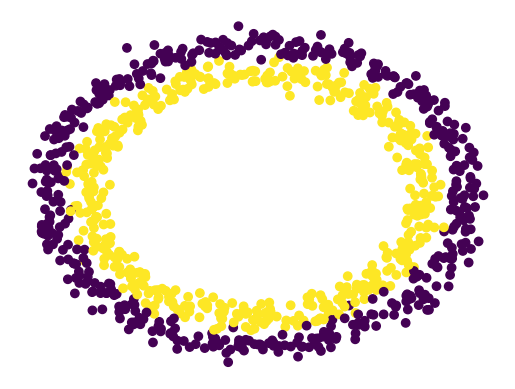

In [14]:
import matplotlib.pyplot as plt
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis(False)

## 3. Turn data into tensors and create train and test dataset

In [15]:
import torch

X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

# View the first five samples
X[:5], y[:5]

(tensor([[ 0.7823,  0.1295],
         [-0.9909, -0.1392],
         [ 0.8333, -0.0113],
         [ 0.7692,  0.6548],
         [-0.3346,  0.6944]]),
 tensor([1., 0., 1., 0., 1.]))

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.2,
                                                    random_state=242)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

## 4. Build a model

In [17]:
from torch import nn

device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [18]:
class CircleModelV0(nn.Module):
    def __init__(self, hidden_units):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=hidden_units[0], out_features=hidden_units[-1])
        self.layer_2 = nn.Linear(in_features=hidden_units[-1], out_features=1)
        self.relu = nn.ReLU()
        
    def forward(self, x):
        return self.layer_2(self.relu(self.layer_1(x)))
    
hidden_units = (2, 5)
model_0 = CircleModelV0(hidden_units).to(device)
model_0

CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layer_2): Linear(in_features=5, out_features=1, bias=True)
  (relu): ReLU()
)

### Also build the same as above using `nn.Sequential`

In [19]:
model_1 = nn.Sequential(
    nn.Linear(in_features=hidden_units[0], out_features=hidden_units[-1]),
    nn.ReLU(),
    nn.Linear(in_features=hidden_units[-1], out_features=1)
).to(device)

model_1

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): ReLU()
  (2): Linear(in_features=5, out_features=1, bias=True)
)

### Setup loss function and optimizer

| **Algorithm**  | **Optimize Way**                                 | **Pros**                                                                 | **Cons**                                                                  |
|----------------|--------------------------------------------------|--------------------------------------------------------------------------|---------------------------------------------------------------------------|
| **Adadelta**   | Adaptive learning rate                           | Reduces the need to set a learning rate, handles sparse data well        | Requires more memory, less intuitive hyperparameter tuning                |
| **Adagrad**    | Adaptive learning rate                           | Automatically adjusts learning rate, good for sparse data                | Learning rate decays too aggressively, can stop learning prematurely      |
| **Adam**       | Adaptive learning rate with momentum             | Combines advantages of Adagrad and RMSprop, works well in practice       | Requires careful hyperparameter tuning, can overfit                       |
| **AdamW**      | Adaptive learning rate with weight decay         | Prevents overfitting by decoupling weight decay from gradient updates    | More hyperparameters to tune                                              |
| **SparseAdam** | Adaptive learning rate with sparse gradient      | Efficient for sparse gradients, reduces memory usage                     | Limited to sparse data                                                    |
| **Adamax**     | Variant of Adam based on infinity norm           | More stable than Adam, works well with high-dimensional data             | Slower convergence in some cases                                          |
| **ASGD**       | Averaged Stochastic Gradient Descent             | Smooths out the noise in SGD, better generalization                      | Slower convergence compared to SGD                                        |
| **LBFGS**      | Quasi-Newton method                              | Faster convergence for certain problems, suitable for smaller datasets   | Requires more memory, less scalable to large datasets                     |
| **NAdam**      | Adam with Nesterov momentum                      | Better convergence properties than Adam, reduces variance                | More complex, requires more hyperparameter tuning                         |
| **RAdam**      | Rectified Adam                                   | Stabilizes training, mitigates variance issues in early stages           | Requires more memory, slightly slower than Adam                           |
| **RMSprop**    | Adaptive learning rate with momentum             | Addresses Adagrad’s learning rate decay, good for non-stationary settings | Requires careful tuning of learning rate and decay parameters             |
| **Rprop**      | Resilient backpropagation                        | Fast convergence for shallow networks, independent of gradient magnitude | Not suitable for noisy or large-scale data, can be sensitive to learning rate |
| **SGD**        | Stochastic Gradient Descent (with momentum)      | Simple, easy to implement, good for large-scale problems                 | Can be slow to converge, requires careful tuning of learning rate         |

In [20]:
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

### Setup metrics for Cls model

In [21]:
from torchmetrics.classification import BinaryAccuracy

### Setup training and testing loop

In [22]:
from tqdm import trange

In [23]:
def train_loop(
    model: nn.Module,
    loss_fn: nn,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    X_train: torch.Tensor,
    y_train: torch.Tensor,
    X_test: torch.Tensor,
    y_test: torch.Tensor,
):
    torch.manual_seed(242)
    X_train, y_train = X_train.to(device), y_train.to(device)
    X_test, y_test = X_test.to(device), y_test.to(device)

    for epoch in range(epochs + 1):
        model.train()

        y_logits = model(X_train).squeeze()
        y_pred = torch.round(torch.sigmoid(y_logits))

        loss = loss_fn(y_logits, y_train)
        metric = BinaryAccuracy()
        acc = metric(y_pred, y_train)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        model.eval()

        with torch.inference_mode():
            test_logits = model(X_test).squeeze()
            test_pred = torch.round(torch.sigmoid(test_logits))

            test_loss = loss_fn(test_logits, y_test)
            metric = BinaryAccuracy()
            test_acc = metric(test_pred, y_test)

        if epoch % 100 == 0:
            print(
                f"Epoch: {epoch} | Train Loss: {loss:.4f}, Train Acc: {acc:.4f} | Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.4f}"
            )

In [24]:
train_loop(model_0, loss_fn, optimizer, 3000, X_train, y_train, X_test, y_test)

Epoch: 0 | Train Loss: 0.7100, Train Acc: 0.4775 | Test Loss: 0.7148, Test Acc: 0.4550
Epoch: 100 | Train Loss: 0.6900, Train Acc: 0.5275 | Test Loss: 0.7017, Test Acc: 0.4700
Epoch: 200 | Train Loss: 0.6884, Train Acc: 0.5263 | Test Loss: 0.6987, Test Acc: 0.4850
Epoch: 300 | Train Loss: 0.6871, Train Acc: 0.5275 | Test Loss: 0.6967, Test Acc: 0.4800
Epoch: 400 | Train Loss: 0.6858, Train Acc: 0.5400 | Test Loss: 0.6949, Test Acc: 0.4900
Epoch: 500 | Train Loss: 0.6843, Train Acc: 0.5350 | Test Loss: 0.6931, Test Acc: 0.4800
Epoch: 600 | Train Loss: 0.6827, Train Acc: 0.5362 | Test Loss: 0.6915, Test Acc: 0.4800
Epoch: 700 | Train Loss: 0.6808, Train Acc: 0.5425 | Test Loss: 0.6896, Test Acc: 0.4850
Epoch: 800 | Train Loss: 0.6787, Train Acc: 0.5400 | Test Loss: 0.6876, Test Acc: 0.4750
Epoch: 900 | Train Loss: 0.6763, Train Acc: 0.5625 | Test Loss: 0.6855, Test Acc: 0.5200
Epoch: 1000 | Train Loss: 0.6730, Train Acc: 0.5938 | Test Loss: 0.6827, Test Acc: 0.5600
Epoch: 1100 | Train Lo